In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm
from scipy import stats

from src.utils import ratemap_collage, weighted_kde, SimpleDatasetMaker
from src.models import RecurrentSpaceNet

plt.style.use("figures/project_style.mplstyle")

In [2]:
## Training parameters
train_steps = 50000

n_in = 2 # Cartesian coordinates, no context
n_out = 100 # no. of spatial representations
timesteps = 10
bs = 32 # batch size

In [3]:
# instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in = n_in, n_out = n_out, corr_across_space= True,
                          scale = 0.3, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

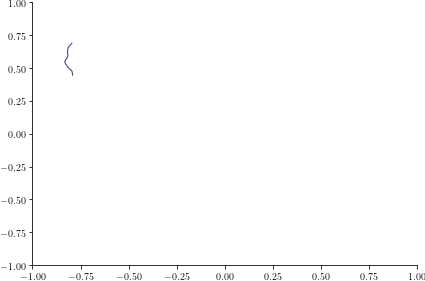

In [4]:
genny = SimpleDatasetMaker()
r, v = genny.generate_dataset(1, timesteps)
plt.plot(*r.detach().numpy().T)
plt.axis([-1, 1, -1, 1])
plt.show()

In [5]:
loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    r_label = r[:,1:]
    loss = model.train_step(x = (v, r[:,0]), y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.001060: 100%|██████████| 50000/50000 [01:40<00:00, 497.36it/s]


Text(0, 0.5, 'Train Loss')

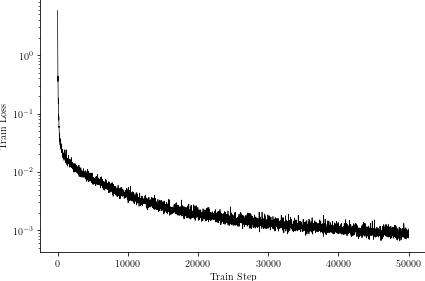

In [6]:
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [7]:
r, v = genny.generate_dataset(5000, timesteps)
model.to("cpu") # inference
p,_ = model.spatial_representation(v, model.p0(r[:,0])[None])
p = p.detach().numpy()

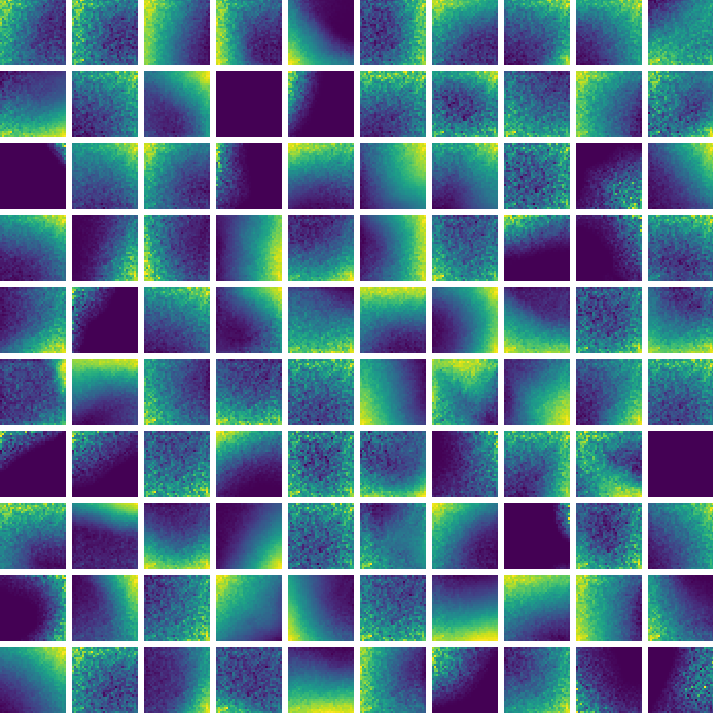

In [23]:
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)
fig, ax = ratemap_collage(ratemaps, cols = 10, figsize = (10,10))

In [9]:
# investigate weights
w = np.copy(model.spatial_representation.weight_hh_l0.detach().numpy())

In [10]:
extent = [-genny.chamber_size, genny.chamber_size]*2
centers = rs[np.argmax(ps, axis = 0)]

bins = 32
x = np.linspace(-1, 1, bins)
xx, yy = np.meshgrid(x,x)
rw = np.stack((xx.ravel(), yy.ravel()),axis = -1)

In [11]:
bw = 0.2

cmap = "seismic"
m = 5
in_kdes = np.array([weighted_kde(centers, w[i], bw)(rw).reshape(bins, bins) for i in range(m)])
out_kdes = np.array([weighted_kde(centers, w[:,i], bw)(rw).reshape(bins, bins) for i in range(m)])

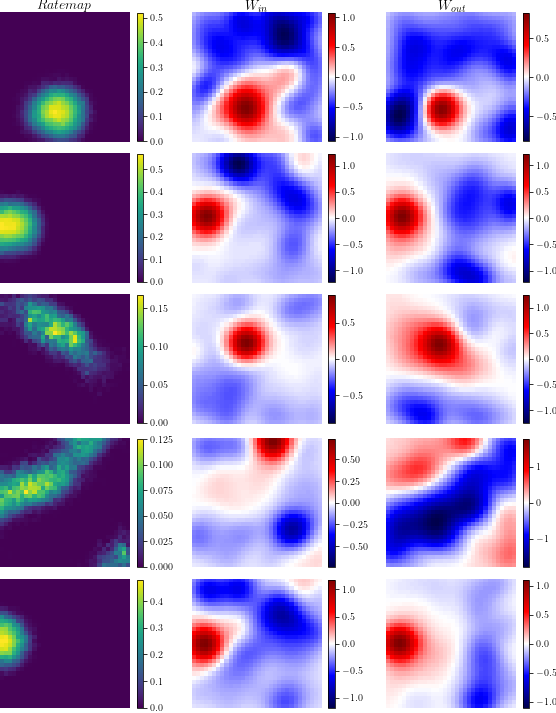

In [12]:
fig, axs = plt.subplots(m, 3, figsize = (8, 10), constrained_layout = True)
axs[0, 0].set_title("$Ratemap$")
axs[0, 1].set_title("$W_{in}$")
axs[0, 2].set_title("$W_{out}$")

for unit in range(m):

    im0 = axs[unit, 0].imshow(ratemaps[unit], origin = "lower",
                       extent = extent)
    fig.colorbar(im0, ax = axs[unit,0], fraction = 0.045)

    vmax = np.amax(np.abs(in_kdes[unit]))
    vmin = -vmax

    im1 = axs[unit, 1].imshow(in_kdes[unit].T, cmap = cmap,extent = extent,
                       vmin = vmin, vmax = vmax, origin = "lower")
    fig.colorbar(im1, ax = axs[unit, 1], fraction = 0.045)

    vmax = np.amax(np.abs(out_kdes[unit]))
    vmin = -vmax
    im2 = axs[unit, 2].imshow(out_kdes[unit].T,cmap = cmap, extent = extent,
                      vmin = vmin, vmax = vmax, origin = "lower")
    fig.colorbar(im2, ax = axs[unit, 2], fraction = 0.045)

    #axs[unit, 1].plot(centers[:,0], centers[:,1],"k.", alpha = 0.5)
    #axs[unit, 2].plot(centers[:,0], centers[:,1],"k.", alpha = 0.5)
    [ax.axis("off") for axis in axs for ax in axis]

In [13]:
class Decoder(torch.nn.Module):
    def __init__(self, n_in, n_out = 2, **kwargs):
        
        super(Decoder, self).__init__(**kwargs)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(n_in, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, n_out))
        
        self.mse = torch.nn.MSELoss()
        
    def forward(self, x):
        return self.decoder(x)

    def train_step(self, x, y, optimizer):
        optimizer.zero_grad()
        loss = self.loss_fn(x, y)
        loss.backward()
        optimizer.step()
        return loss.item()
        
    def loss_fn(self, x, y):
        y_pred = self(x)
        return self.mse(y_pred, y)

In [14]:
decoder = Decoder(n_in = n_out, n_out = 2) # :o)
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)

In [15]:
loss_history = []

train_steps = 10000
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    p = model.spatial_representation(v, model.p0(r[:,0])[None])[0].detach()
    p = p.detach() 
    p = torch.reshape(p, (-1, p.shape[-1]))
    r_label = r[:,1:].reshape(-1, 2)
    loss = decoder.train_step(x = p, y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000216: 100%|██████████| 10000/10000 [00:11<00:00, 888.56it/s]


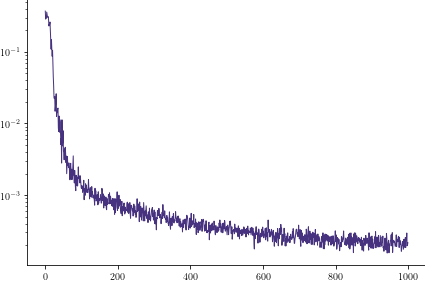

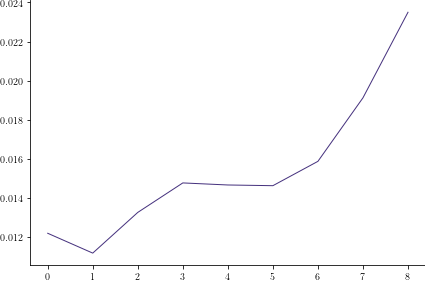

In [16]:
plt.semilogy(loss_history)
plt.show()
pred = decoder(p).detach().numpy()
error = np.linalg.norm(pred - r_label.detach().numpy(), axis = -1)
decoder_error = error.reshape(bs, timesteps - 1)
plt.plot(np.mean(decoder_error, axis = 0))
plt.show()

In [17]:
class RecurrentNet(torch.nn.Module):
    def __init__(self, n_in, n_out = 2, **kwargs):
        super().__init__(**kwargs)
        self.device = device
        
        self.p0 = torch.nn.Sequential(
                torch.nn.Linear(n_in, 64),
                torch.nn.ReLU(),
                torch.nn.Linear(64, n_out),
                torch.nn.ReLU())

        self.spatial_representation = torch.nn.RNN(
            input_size = n_in,
            hidden_size = n_out,
            nonlinearity= "relu",
            bias=False,
            batch_first=True)        

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(n_out, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, n_in))    

        torch.nn.init.eye_(self.spatial_representation.weight_hh_l0) # identity initialization
        self.mse = torch.nn.MSELoss()
    
    def forward(self, inputs):
        # RNN returns representations and final hidden state
        initial_state = self.p0(inputs[1])
        p, _ = self.spatial_representation(inputs[0], initial_state[None])
        return self.decoder(p)

    def train_step(self, x, y, optimizer):
        optimizer.zero_grad()
        loss = self.loss_fn(x, y)
        loss.backward()
        optimizer.step()
        return loss.item()
        
    def loss_fn(self, x, y):
        y_pred = self(x)
        return self.mse(y_pred, y)

In [18]:
recnet = RecurrentNet(n_in = n_in, n_out = n_out) # :o)
optimizer = torch.optim.Adam(recnet.parameters(), lr=1e-4)

In [19]:
loss_history = []

train_steps = 10000
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    loss = recnet.train_step(x = (v, r[:,0]), y = r[:,1:], optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000008: 100%|██████████| 10000/10000 [00:16<00:00, 597.79it/s]


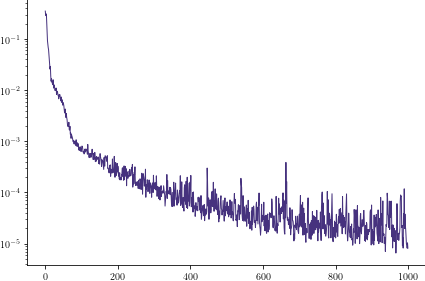

In [20]:
plt.semilogy(loss_history)

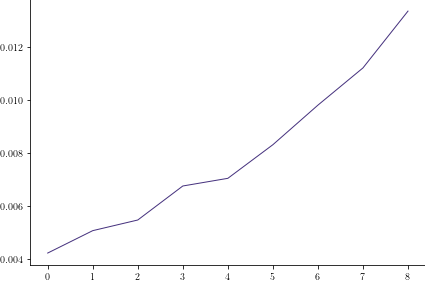

In [21]:
pred = recnet((v, r[:,0])).detach().numpy()
error = np.linalg.norm(pred - r[:,1:].detach().numpy(), axis = -1)
recnet_error = error.reshape(bs, timesteps-1,  -1)
plt.plot(np.mean(recnet_error, axis = 0))

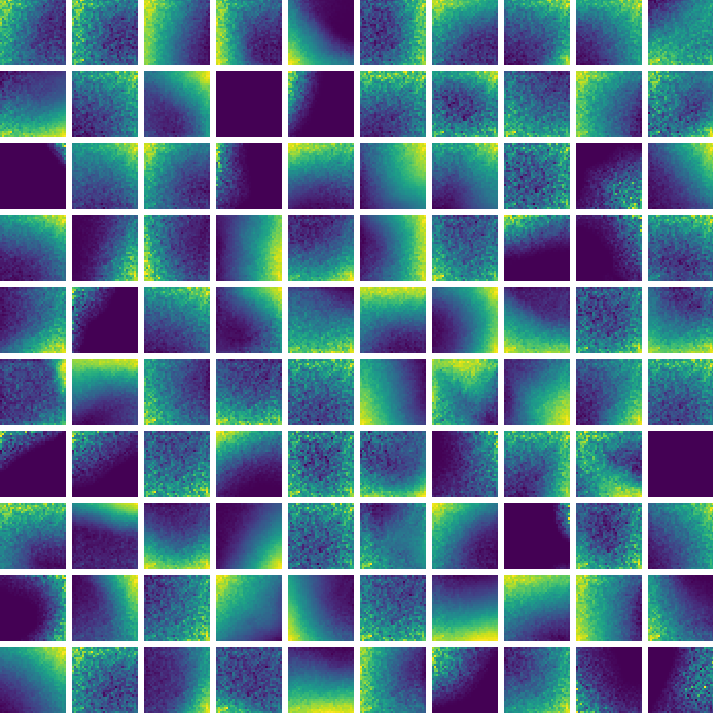

In [22]:
r, v = genny.generate_dataset(5000, timesteps)
# inference
model.to("cpu")
p,_ = recnet.spatial_representation(v, recnet.p0(r[:,0])[None])
p = p.detach().numpy()

ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)

fig, ax = ratemap_collage(ratemaps, cols = 10, figsize = (10,10), constrained_layout = True)